In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.lines import Line2D

from models.pipeline import Pipeline
from dataset.ba_dataset import BaDataset1D2D, GISAXSDataModule
from experiments.utils import *
from experiments.inference import *
from experiments.abc import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/zhdano82/.conda/envs/pyg/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/zhdano82/.conda/envs/pyg/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


# Load model

In [3]:
config = dict(
    context_dim=96,
    flow_hidden=64,
    hidden_dim_dec=4,
    hidden_dim_enc=16,
    latent_dim=4)

cvae_params = dict(
    latent_dim=config['latent_dim'],
    context_dim=config['context_dim'], 
    hidden_dim_enc=config['hidden_dim_enc'],
    hidden_dim_dec=config['hidden_dim_dec'],
    n_samples=1,
    drop_prob=0.1,
)

In [4]:
pipe = Pipeline(n_layers=12, n_transforms=8, hidden_dim=config['flow_hidden'], 
                cvae_params=cvae_params, lr=1e-3, step_lr=10)

In [5]:
pipe.load_state_dict(torch.load('saved_models/pipe_650000_361655.pt'))

<All keys matched successfully>

# Load data

In [6]:
# first, let's load data corresponding to Lisa's fit
# it is saved with index 700000.
lisa_fit = BaDataset1D2D('/bigdata/hplsim/aipp/Maksim/BA_simulation/complete/', indices=range(700000,700001), 
                        to_preload=True, to_augment=False, in_shape=(1024,512), out_shape=(128,16), 
                        mask=True, order=True, log=True, minmax=True)

100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


In [7]:
# experimental signal (pre-shot)
run_1 = np.loadtxt('/bigdata/hplsim/aipp/Maksim/BA_simulation/exp_data/lisa_data/run_49169.txt',dtype=float)
# experimental background signal
run_0 = np.loadtxt('/bigdata/hplsim/aipp/Maksim/BA_simulation/exp_data/lisa_data/run_49227.txt', dtype=float)
# subtract the background (Lisa's fit)
run_1 = run_1 - run_0*30/1000

In [8]:
# preprocess experimental data (routine given by Lisa)
a,b = compile_exp(run_1)
profile_exp = np.concatenate([a,b])
profile_exp = torch.tensor(profile_exp)

# get simulated data (already preprocessed)
pattern_sim = lisa_fit.X[0]
profile_sim = lisa_fit.x[0]
params_sim = lisa_fit.y[0]

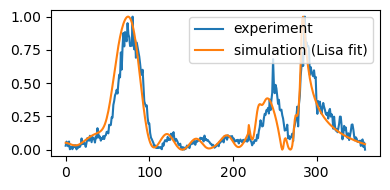

In [9]:
# plot simulated in-plane signal vs. the experimental one
plt.figure(figsize=(4,2))
plt.plot(profile_exp, label = 'experiment')
plt.plot(profile_sim, label = 'simulation (Lisa fit)')
plt.legend()
plt.tight_layout()

# Inference

## Estimate log-probability 

In [10]:
pipe = pipe.float().eval()

In [11]:
# add batch dimension to data
profile_exp = profile_exp.float().unsqueeze(0)
params_exp = params_sim.float().unsqueeze(0)
profile_sim = profile_sim.float().unsqueeze(0)
pattern_sim = pattern_sim.float().unsqueeze(0)
params_sim = params_sim.float().unsqueeze(0)

In [12]:
lp_1d = cvae_log_prob(pipe, profile_exp, params_sim).mean().item()

In [13]:
lp_2d1d = cvae_log_prob_profile(pipe, pattern_sim, profile_sim, params_sim).mean().item()

In [14]:
print("Lisa's fit        ---> log p(y|X,x): {:.2f}".format(lp_2d1d) + ' (both 2D GISAXS image and 1D in-plane signal are given)')
print('experimental data ---> log p(y|x): {:.2f}'.format(lp_1d)+ '   (only experimental 1D in-plane signal are given)') 

Lisa's fit        ---> log p(y|X,x): -25.95 (both 2D GISAXS image and 1D in-plane signal are given)
experimental data ---> log p(y|x): -28.21   (only experimental 1D in-plane signal are given)


## Reconstruct 2D image from an in-plane scattering profile

In [15]:
_,_,inputs = map_sample(pipe.to(device), profile_exp.to(device), 100)
# decode the 2D image from the context
with torch.no_grad():
    x_hat = pipe.cvae.decoder(inputs.unsqueeze(0))

/home/zhdano82/.conda/envs/pyg/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


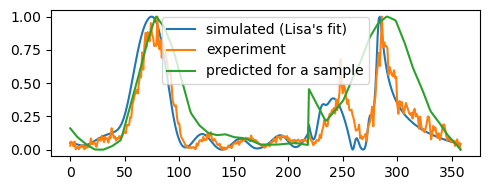

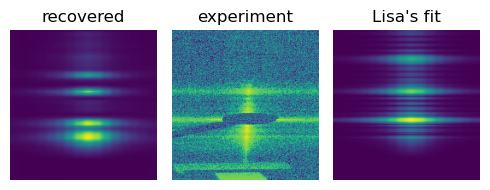

In [16]:
# plot in-plane scattering profiles
plt.figure(figsize=(5,2))
plt.plot(profile_sim.cpu().detach().squeeze(), label="simulated (Lisa's fit)")
plt.plot(profile_exp.cpu().detach().squeeze(), label='experiment')
plt.plot(get_lowdim_profile(x_hat.squeeze()).cpu().detach(), label='predicted for a sample')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,2))
plt.subplot(1,3,1)
plt.imshow(x_hat.cpu().detach().squeeze(), aspect = 'auto')
plt.title('recovered')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(lisa_fit.transform(torch.tensor(run_1))[0], aspect = 'auto')  
plt.title('experiment')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(pattern_sim.cpu().detach().squeeze(), aspect = 'auto')
plt.title("Lisa's fit")
plt.axis('off')
plt.tight_layout()
plt.show()

## Approximate Bayesian computation

In [17]:
# let us preload our training data with (x,X,y) ~ p(x,X,y)
n_dp = 10000
n_layers = 12

train_file = f'/bigdata/hplsim/aipp/Maksim/BA_simulation/exp_data/data_{n_layers}_{n_dp}.pt'
test_file = f'/bigdata/hplsim/aipp/Maksim/BA_simulation/exp_data/data_{n_layers}_test.pt'
preloaded_files = {'train': train_file, 'test_file': test_file}

data_module = GISAXSDataModule(mode='1d2d', batch_size=32, preloaded_files=preloaded_files, path='', 
                               indices=None, to_preload=False, to_augment=False,
                               in_shape=(1024,512), out_shape=(128,16),
                               sigma=None, drop_y=None, sp_prob=None, 
                               mask=True, verbose=True, order=False)
data_module.setup();

/home/zhdano82/SimBasedInference/gisaxs-reconstruction/dataset/ba_dataset.py:69: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  self.X = np.array(self.X)[np.where(nons)[0]]
/home/zhdano82/SimBasedInference/gisaxs-reconstruction/dataset/ba_dataset.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.X = np.array(self.X)[np.where(nons)[0]]
/home/zhdano82/SimBasedI

In [18]:
# select the data to work with: 2D GISAXS or 1D in-plane scattering profile
# WARNING: the analysis in the paper is based on 1D case. Hence, use 1d for analysis, 2d for fun.
abc_mode = '2d'

In [19]:
if abc_mode == '1d':
    abc = ABC(epsilon=5, n_params=12*6, mode='1d')
    abc.estimate_data(data_ref=profile_exp.cpu().detach(), dataset=data_module.gisaxs_train, verbose=True)
else:
    abc = ABC(epsilon=5, n_params=12*6, mode='2d')
    abc.estimate_data(data_ref=pattern_sim.squeeze(), dataset=data_module.gisaxs_train, verbose=True)

100%|██████████| 8000/8000 [00:01<00:00, 6709.87it/s]


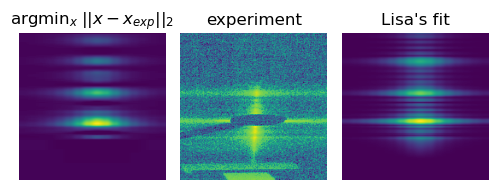

In [20]:
# let's see how close the ABC fit (argmax_x p(y|x)) to the ground truth data
if abc_mode == '1d':
    plt.figure(figsize=(5,2))
    plt.plot(profile_sim.cpu().detach().squeeze(), label="simulated (Lisa's fit)")
    plt.plot(profile_exp.cpu().detach().squeeze(), label='experiment')
    plt.plot(abc.best_x.squeeze(), label=r'argmin$_x \; ||x - x_{exp}||_2$')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(5,2))
    plt.subplot(1,3,1)
    plt.imshow(abc.best_x.cpu().detach().squeeze(), aspect = 'auto')
    plt.title(r'argmin$_x \; ||x - x_{exp}||_2$')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(lisa_fit.transform(torch.tensor(run_1))[0], aspect = 'auto')  
    plt.title('experiment')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(pattern_sim.cpu().detach().squeeze(), aspect = 'auto')
    plt.title("Lisa's fit")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Posterior p(y|X,x)

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [35]:
vae_samples = 32
nf_samples = 1000
with torch.no_grad():
    # z ~ p(z)
    z = 0.1*torch.randn(1, vae_samples, pipe.cvae.latent_dim).reshape(-1, pipe.cvae.latent_dim)
    # c = [in-plane prof. || z]
    c = pipe.to(device).cvae.get_context(profile_exp.to(device), z.to(device), vae_samples)
    # y ~ p(y|c)
    nf_y = pipe.flow.sample(nf_samples // vae_samples, c).reshape(-1,72)

In [36]:
# get sample parameters estimated by Lisa
y_fit = get_lisa_fit()
# ABC's best fit
y_abc = np.array(abc.best_params).reshape(12,6)
# NF's best fit
y_nf = nf_y.mean(0)
y_nf = y_nf.cpu().detach().numpy().reshape(12,6)

In [37]:
# let us specify comparison parameters
N = 1000 # number of samples to take from ABC (reduced for the sake of time)
layer = 10 # layer's parameters (only 1 is taken for compact visualization)

abc_y = abc.out[:N,(6*layer):(6*(layer+1))]
# draw equal number of samples from NF
nf_y = nf_y[torch.randperm(nf_y.size()[0])]
nf_y = nf_y[:len(abc_y),(6*layer):(6*(layer+1))].cpu().detach()

In [38]:
sample_data = torch.cat([abc_y, nf_y])
titles =  ['ABC + KDE']*len(abc_y) + ['NFs+CVAEs (Ours)']*len(nf_y)

# turn the data into a pandas dataframe
df = pd.DataFrame(sample_data.numpy())
df['alg'] = titles
df.columns = ['absorption', 'dispersion', 'thickness', 'roughness', 'Hurst', 'lat. corrlen', 'alg']

<Figure size 640x480 with 0 Axes>

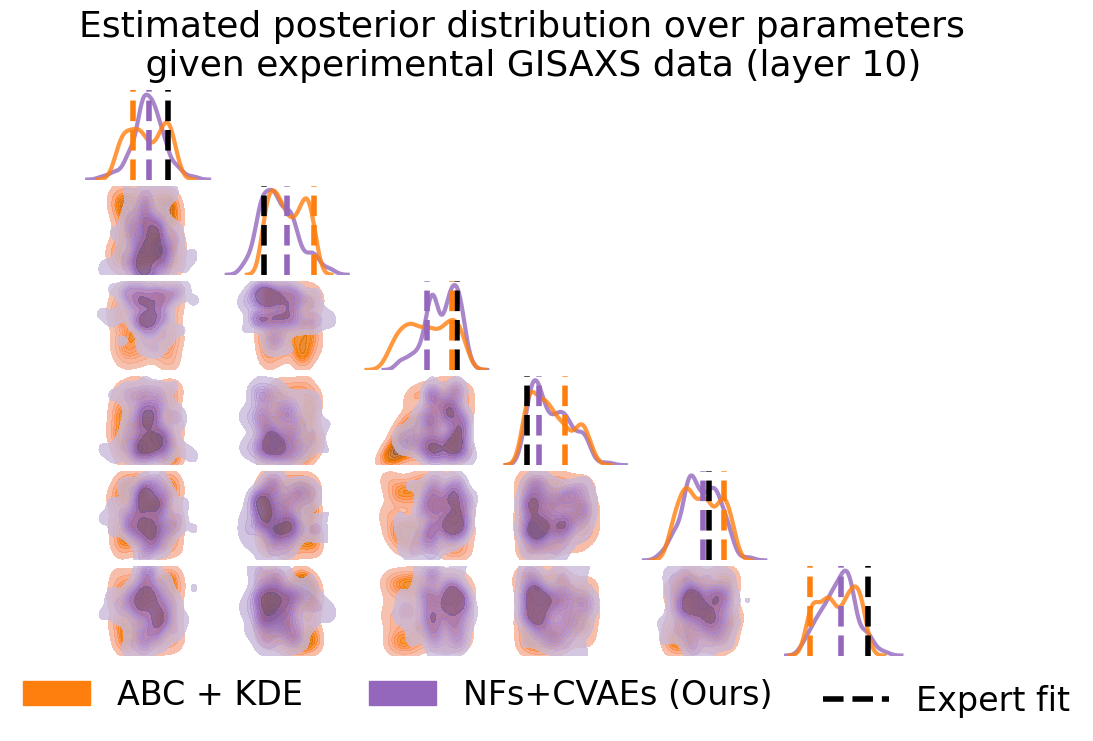

In [39]:
# Let us now draw the posterior distribution for the specified layer.
# We use pairplot from seaborn. Also, we draw the best fit of each framework with vertical lines.
fig = plt.figure()
g = sns.pairplot(df, hue="alg", kind='kde', corner=True, 
                 plot_kws={'fill':True, 'alpha':0.8, 'palette': 'PuOr', 'bw_adjust':0.8}, 
                 diag_kws={'fill':False, 'alpha':0.8, 'linewidth':3., 'bw_adjust':0.8}, palette={'ABC + KDE':'tab:orange', 'NFs+CVAEs (Ours)':'tab:purple'}) #.set_title('Estimated posterior distribution over parameters given experimental GISAXS data')
# remove all the axis and ticks
for ax in g.axes.flatten():
    try:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_ylim(-0.1,1.1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    except:
        pass
# add y with the highest probability according to each framework
for idx, ax in enumerate(g.axes.flatten()):
    p_idx = idx // 6
    if ax in g.axes.diagonal():
        ax2 = ax.twinx()
        ax2.set_ylim(df.index.min(), df.index.max()) 
        # and hide it
        ax2.get_yaxis().set_visible(False)
        ax2.grid(False)
        ax2.axvline(x=y_fit[0,p_idx], color='black', linestyle='--', label = 'true value', lw=4)
        ax2.axvline(x=y_abc[0,p_idx], color='tab:orange', linestyle='--', label = 'true value', lw=4)
        ax2.axvline(x=y_nf[0,p_idx], color='tab:purple', linestyle='--', label = 'true value', lw=4)
    else:
        pass    
    
sns.despine(top=True, right=True, left=True, bottom=True)
sns.move_legend(g, loc='lower center', ncol=3, bbox_to_anchor=(.37, -0.1), title=None, frameon=False, fontsize=24)
        
g.fig.set_figheight(6)
g.fig.set_figwidth(10)

g.fig.suptitle(f"Estimated posterior distribution over parameters \n given experimental GISAXS data (layer {layer})", y=1.12, fontsize=26)
plt.legend([Line2D([0], [0], color=c, linewidth=4, linestyle='--') for c in ['black']], 
           ['Expert fit'], 
           frameon=False, prop={'size': 24}, bbox_to_anchor=(0., -0.22, 2.52, 0.23))
#plt.savefig('./pairplot.png', bbox_inches='tight', dpi=1000)